<a href="https://colab.research.google.com/github/mrudulmamtani/BSEforecast/blob/main/BSE_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import yfinance as yf
import pandas as pd

In [38]:
bse = yf.Ticker("^BSESN")
bse = bse.history(period="max")
bse.to_csv("bse.csv")

In [3]:
bse.index = pd.to_datetime(bse.index)

In [4]:
bse

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-07-01 00:00:00+05:30,4263.109863,4301.770020,4247.660156,4300.859863,0,0.0,0.0
1997-07-02 00:00:00+05:30,4302.959961,4395.310059,4295.399902,4333.899902,0,0.0,0.0
1997-07-03 00:00:00+05:30,4335.790039,4393.290039,4299.970215,4323.459961,0,0.0,0.0
1997-07-04 00:00:00+05:30,4332.700195,4347.589844,4300.580078,4323.819824,0,0.0,0.0
1997-07-07 00:00:00+05:30,4326.810059,4391.009766,4289.490234,4291.450195,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-09-29 00:00:00+05:30,65743.929688,66151.648438,65570.382812,65828.406250,8400,0.0,0.0
2023-10-03 00:00:00+05:30,65813.421875,65813.500000,65344.589844,65512.101562,8600,0.0,0.0
2023-10-04 00:00:00+05:30,65330.648438,65332.519531,64878.769531,65226.039062,8600,0.0,0.0


<Axes: xlabel='Date'>

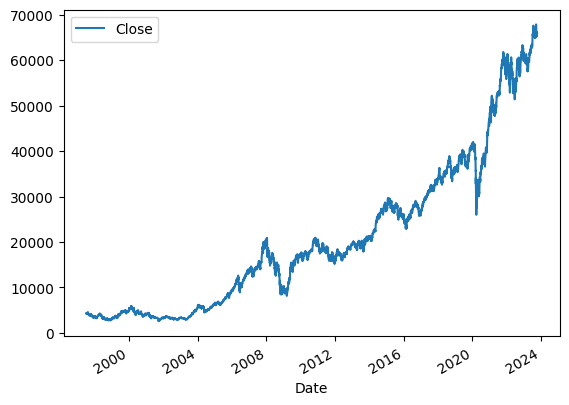

In [5]:
bse.plot.line(y="Close", use_index=True)

In [6]:
del bse["Dividends"]
del bse["Stock Splits"]

In [7]:
bse["Tomorrow"] = bse["Close"].shift(-1)

In [8]:
bse["Target"] = (bse["Tomorrow"] > bse["Close"]).astype(int)

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = bse.iloc[:-100]
test = bse.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [17]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds, zero_division='warn')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

<Axes: xlabel='Date'>

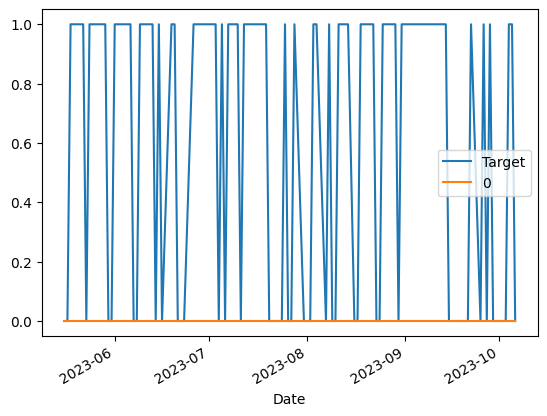

In [18]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [19]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [20]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [22]:
predictions = backtest(bse, model, predictors)

In [23]:
predictions["Predictions"].value_counts()

0    2424
1    1549
Name: Predictions, dtype: int64

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5190445448676565

In [25]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.527058
0    0.472942
Name: Target, dtype: float64

In [27]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = bse.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    bse[ratio_column] = bse["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    bse[trend_column] = bse.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [28]:
bse = bse.dropna(subset=bse.columns[bse.columns != "Tomorrow"])

In [29]:
bse

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2001-07-20 00:00:00+05:30,3375.820068,3389.489990,3331.419922,3340.750000,0,3330.979980,0,0.995503,0.0,0.984784,0.0,0.958136,27.0,0.852056,130.0,0.837352,512.0
2001-07-23 00:00:00+05:30,3340.889893,3340.889893,3310.949951,3330.979980,0,3335.080078,1,0.998536,0.0,0.987952,0.0,0.955753,27.0,0.850547,130.0,0.835113,511.0
2001-07-24 00:00:00+05:30,3326.840088,3340.909912,3306.169922,3335.080078,0,3301.969971,0,1.000615,1.0,0.994884,1.0,0.957773,27.0,0.852337,131.0,0.836348,512.0
2001-07-25 00:00:00+05:30,3307.159912,3338.219971,3296.429932,3301.969971,0,3259.030029,0,0.995011,1.0,0.989816,1.0,0.949338,26.0,0.844768,130.0,0.828258,511.0
2001-07-26 00:00:00+05:30,3298.639893,3318.600098,3254.280029,3259.030029,0,3251.530029,0,0.993455,0.0,0.983543,1.0,0.938051,26.0,0.834579,130.0,0.817698,511.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29 00:00:00+05:30,65743.929688,66151.648438,65570.382812,65828.406250,8400,65512.101562,0,1.002437,1.0,0.999142,3.0,0.997398,36.0,1.061348,142.0,1.278851,548.0
2023-10-03 00:00:00+05:30,65813.421875,65813.500000,65344.589844,65512.101562,8600,65226.039062,0,0.997592,1.0,0.995888,2.0,0.992674,35.0,1.055641,142.0,1.272004,548.0
2023-10-04 00:00:00+05:30,65330.648438,65332.519531,64878.769531,65226.039062,8600,65631.570312,1,0.997812,0.0,0.993713,2.0,0.988353,35.0,1.050435,142.0,1.265744,548.0


In [30]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [32]:
predictions = backtest(bse, model, new_predictors)

In [33]:
predictions["Predictions"].value_counts()

0.0    2645
1.0     328
Name: Predictions, dtype: int64

In [34]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6219512195121951

In [35]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.534813
0    0.465187
Name: Target, dtype: float64

In [36]:
predictions

,Target,Predictions
Date,,
2011-08-25 00:00:00+05:30,0,0.0
2011-08-26 00:00:00+05:30,1,0.0
2011-08-29 00:00:00+05:30,1,1.0
2011-08-30 00:00:00+05:30,1,1.0
2011-09-02 00:00:00+05:30,0,0.0
...,...,...
2023-09-29 00:00:00+05:30,0,0.0
2023-10-03 00:00:00+05:30,0,0.0
2023-10-04 00:00:00+05:30,1,0.0
